---
title: Correlation of Enformer CAGE predictions on rn7 reference genome and measured gene expression in Br rats
author: Sabrina Mi
date: 8/23/2023
description: Correlation of predicted reference gene expression and Br mean gene expression is 0.45, with the chromosome with lowest correlation being 0.19 on chromosome 18 and the highest being 0.61 on chromosome 7. While this is reasonable compared to 0.54 correlation between Enformer predictions and GTEx observed expression across human genes, I believe the correlation across rat genes would be even higher if we used Br population data for the reference genome, as the Br population noticeably diverges from reference rats (many alternative homozygotes).

---

## Concatenate Predictions

We start with concatenating our predictions into separate files by chromosome number, firstly because our predictions are currently split between two directories and secondly, by grouping intervals together by chromosome, we can parallelize computing gene expression.

In [2]:
import glob
import os
import h5py
import parsl
from parsl import python_app
from parsl.configs.local_threads import config
parsl.load(config)


In [3]:
output_dir = "/home/s1mi/Br_predictions/predictions_folder/reference_Br_all_genes"
chr_list = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "X"]

In [4]:
@python_app
def concatenate_predictions_by_chromosome(predictions_dir, chr, output_dir):
    output_path = os.path.join(output_dir, f"chr{chr}_predictions.h5")
    with h5py.File(output_path, "a") as output_file:
        files = glob.glob(f"{predictions_dir}/chr{chr}*_predictions.h5")
        for file in files:
            interval = os.path.basename(file).replace("_predictions.h5", "")
            with h5py.File(file, "r") as input_file:
                output_file[interval] = input_file[interval][()]
            

In [5]:
## concatenate files in first prediction run
predictions_dir = f"{output_dir}/predictions_2023-08-16/enformer_predictions/reference_Br/haplotype0"
app_futures = []
for chr in chr_list:
    app_futures.append(concatenate_predictions_by_chromosome(predictions_dir, chr, output_dir))
exec_futures = [q.result() for q in app_futures]

In [13]:
## concatenate files in second prediction run
predictions_dir = f"{output_dir}/predictions_2023-08-29/enformer_predictions/reference_Br/haplotype0"
app_futures = []
for chr in chr_list:
    app_futures.append(concatenate_predictions_by_chromosome(predictions_dir, chr, output_dir))

exec_futures = [q.result() for q in app_futures]

Second prediction folder done


## Compare Predicted and Observed

In [11]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import parsl
from parsl import python_app
from parsl.configs.local_threads import config
parsl.load(config)

In [4]:
project_dir = "/home/s1mi/Br_predictions/predictions_folder/reference_Br_all_genes"
chr_list = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "X"]
rn7_annot = pd.read_csv('/home/s1mi/enformer_rat_data/annotation/rn7.gene.txt', sep ='\t')
gene_dict = rn7_annot.groupby('chromosome')['geneId'].apply(list).to_dict()

/tmp/ipykernel_89896/1953959868.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  rn7_annot = pd.read_csv('/home/s1mi/enformer_rat_data/annotation/rn7.gene.txt', sep ='\t')


In [5]:
## filter genes to chr1-20 and X and make chr all strings
gene_dict = {str(key): value for key, value in gene_dict.items() if str(key) in chr_list}

In [6]:
tpm = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", header=0, index_col='gene_id')
mean_tpm = tpm.iloc[:,3:].mean(axis=1)
mean_tpm.name = 'observed'

/tmp/ipykernel_89896/417279503.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tpm = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", header=0, index_col='gene_id')


In [15]:
## Function to put CAGE predictions in list (in the same order as gene list by chromosome)
@python_app
def query_genes(chr):
    gene_list = gene_dict[chr]
    with h5py.File(f"{project_dir}/chr{chr}_predictions.h5", "r") as file:
        for gene in gene_list:
            interval = f"chr{chr}_{rn7_annot.loc[gene]['tss']}_{rn7_annot.loc[gene]['tss']}"
            bins = file[interval][446:450, 4980]
            CAGE_predictions[chr].append(np.average(bins))

In [19]:
rn7_annot.set_index("geneId", inplace=True)
CAGE_predictions = {chr: [] for chr in chr_list}
app_futures = []
## Collect CAGE predictions in parallel across genes
for chr in chr_list:
    app_futures.append(query_genes(chr))
## Wait for all chromosomes to finish
exec_futures = [q.result() for q in app_futures]

In [21]:
merged_dict = {}
for chr in chr_list:
    merged_dict[chr] = pd.DataFrame(index=gene_dict[chr])
    merged_dict[chr]['predicted'] = CAGE_predictions[chr]
    merged_dict[chr]['observed'] = mean_tpm.loc[gene_dict[chr]]

In [23]:
all_genes = pd.concat(merged_dict.values())
all_genes.to_csv("/home/s1mi/enformer_rat_data/output/rn7_reference_predicted_vs_observed_expression.csv")

Correlation across all rn7 genes: 0.45259620551544333


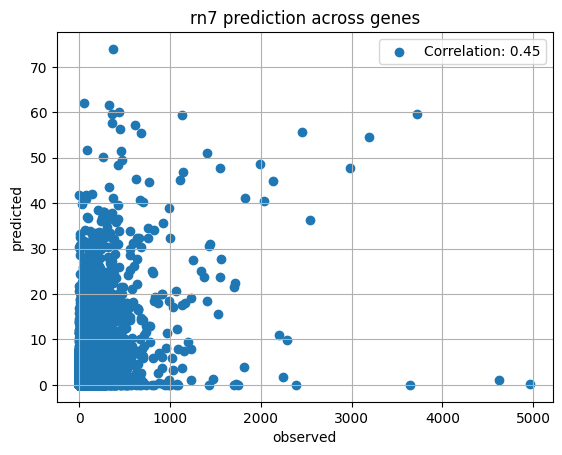

In [33]:
corr = all_genes.corr().iloc[0,1]
print("Correlation across all rn7 genes:", corr)
plt.scatter(all_genes['observed'], all_genes['predicted'], label=f'Correlation: {corr:.2f}')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title("rn7 prediction across genes")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
for chr in chr_list:
    print(len(gene_dict[chr]), "genes on chromosome", chr, "\tcorrelation =", merged_dict[chr].corr().iloc[0,1])

3953 genes on chromosome 1 	correlation = 0.476354606549354
2003 genes on chromosome 2 	correlation = 0.5218130288311454
2030 genes on chromosome 3 	correlation = 0.4610018149991454
1959 genes on chromosome 4 	correlation = 0.5244393504977057
1780 genes on chromosome 5 	correlation = 0.22610655969051743
1390 genes on chromosome 6 	correlation = 0.5712413035540091
1648 genes on chromosome 7 	correlation = 0.6087498490236489
1612 genes on chromosome 8 	correlation = 0.4427092910204691
1146 genes on chromosome 9 	correlation = 0.5372756452275427
2127 genes on chromosome 10 	correlation = 0.5956000550961525
832 genes on chromosome 11 	correlation = 0.4791331079400649
909 genes on chromosome 12 	correlation = 0.585056162086108
881 genes on chromosome 13 	correlation = 0.47875298103605635
989 genes on chromosome 14 	correlation = 0.44209977697290426
1000 genes on chromosome 15 	correlation = 0.48793264345973547
843 genes on chromosome 16 	correlation = 0.5956281375952103
620 genes on chromos